In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from itertools import chain

Using TensorFlow backend.


In [3]:
def load_data():
    ann = pd.read_csv('100.csv')
    ann.drop(['Sub', 'Chan', 'Num', 'Aux'], axis = 1, inplace=True)
    sig = pd.read_csv('100.sig.csv')
    scaler = MinMaxScaler()
    #scaler = StandardScaler()
    sig[['MLII', 'V5']] = scaler.fit_transform(sig[['MLII', 'V5']])
    return ann, sig

In [3]:
def plot(sample, delta = 392):
    plt.figure(figsize=(14,12))
    sig1 = sig['MLII'][sample - delta:sample + delta]
    sig2 = sig['V5'][sample - delta:sample + delta]
    plt.scatter(sample, np.fmin(sig1.min(), sig2.min()), c='red')
    for j, k in enumerate([3,5,7]):
        plt.subplot(3,1,1 + j)
        s1 = [np.mean(sig1[i:i + k]) for i, _ in enumerate(sig1)]        
        plt.plot(sig1.values)
        plt.plot(s1)

    plt.figure(figsize=(14,12))
    for j, k in enumerate([1,3,5]):
        plt.subplot(3,1,1 + j)
        plt.plot(pd.ewma(sig1, k, adjust=False))
        sig1.plot()

In [5]:
#plot(599, 392)

### Autoencoder

In [4]:
def create_encoding_layers(units = [128, 64, 32]):
    return [Dense(u, activation='relu') for u in units]

def create_decoding_layers(units = [64, 128, 784]):
    return [Dense(u, activation='relu' if i < len(units) -1 else 'sigmoid') for i, u in enumerate(units)]

def create_encoding_conv_pool_layers(kernels = [16, 8, 8]):    
    conv = [Conv2D(k, (3, 3), activation='relu', padding='same') for k in kernels]
    bn = [BatchNormalization() for k in kernels]
    pool = [MaxPooling2D((2, 2), padding='same') for k in kernels]
    return list(chain(*zip(conv, bn, pool)))

def create_decoding_conv_pool_layers(kernels = [8, 8, 16]):
    conv = [Conv2D(k, (3, 3), activation='relu', \
                   padding='same' if i < len(kernels) - 1 else 'valid') for i, k in enumerate(kernels)]    
    pool = [UpSampling2D((2, 2)) for k in kernels]
    last = Conv2D(1, (3, 3), activation='sigmoid', padding='same')
    return list(chain(*zip(conv, pool), [last]))

def connect_layers(input, layers):
    for i,l in enumerate(layers):
        if i == 0:
            layer = l(input)
        else:
            layer = l(layer)
    return layer

In [5]:
def create_encoders(input_dim = 784, layers_dim = [128, 64], encoding_dim = 32):    
    normal_input  = Input(shape=(input_dim,))
    encoded_input = Input(shape=(encoding_dim,))

    encoding_layers = create_encoding_layers(layers_dim + [encoding_dim])
    layers_dim.reverse()
    decoding_layers = create_decoding_layers(layers_dim + [input_dim])

    encoded = connect_layers(normal_input, encoding_layers)
    decoded = connect_layers(encoded, decoding_layers)
    semi_decoded = connect_layers(encoded_input, decoding_layers)

    autoencoder = Model(normal_input, decoded)
    encoder = Model(normal_input, encoded)
    decoder = Model(encoded_input, semi_decoded)

    return autoencoder, encoder, decoder

In [6]:
def create_conv_encoders(input_dim = (28, 28), kernels = [16, 8, 8], encoding_dim = (4, 4)):
    normal_input = Input(shape=(*input_dim, 1))  # adapt this if using `channels_first` image data format
    encoded_input = Input(shape=(*encoding_dim, kernels[-1]))

    encoding_layers = create_encoding_conv_pool_layers(kernels)
    kernels.reverse()
    decoding_layers = create_decoding_conv_pool_layers(kernels)

    encoded = connect_layers(normal_input, encoding_layers)
    decoded = connect_layers(encoded, decoding_layers)
    semi_decoded = connect_layers(encoded_input, decoding_layers)

    autoencoder = Model(normal_input, decoded)
    encoder = Model(normal_input, encoded)
    decoder = Model(encoded_input, semi_decoded)

    return autoencoder, encoder, decoder

In [7]:
def fit(autoencoder, x_train, x_test, epochs = 50, loss = 'binary_crossentropy'):
    autoencoder.compile(optimizer='adadelta', loss = loss)
    return autoencoder.fit(x_train, x_train,
                    epochs=epochs,
                    batch_size=512,
                    shuffle=True,
                    validation_data=(x_test, x_test), verbose = 1,
                    callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

In [9]:
ann, sig = load_data()

In [17]:
def get_train_test_set(shape = (784, )):
    x, delta = [], int(784 / 2)
    for i in ann[ann['Type'] == 'N']['Sample #']:
        if i >= delta and i < len(sig) - delta:
            s = np.array(sig['MLII'][i - delta:i + delta])        
#             s = np.array([np.mean(s[i:i + 5]) for i, _ in enumerate(s)])
            x.append(s.reshape(shape))
    x_train = np.array(x)        
    x_test = np.copy(x_train)
    return x_train, x_test

In [23]:
def plot_diagrams(x_test, x_decoded):
    n, figsize = 10, (20, 3)
    plt.figure(figsize=figsize)
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(x_decoded[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()    
    plt.figure(figsize=figsize)
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.plot(x_test[i].reshape((784)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax = plt.subplot(2, n, i + 1 + n)
        plt.plot(x_decoded[i].reshape((784)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [37]:
def plot_loss_accuracy(loss, x_test, x_decoded):
    plt.figure(figsize=(14,3))
    plt.subplot(1,2,1)
    plt.plot(loss.history['loss'])    
    plt.subplot(1,2,2)
    plt.plot(x_test[0].reshape((784)))
    plt.plot(x_decoded[0].reshape((784)))

In [34]:
def load_weights(model, filename, load_prev):
    if filename is not None and load_prev:
        try:
            model.load_weights(filename, by_name=False)
            print('Succesfully loaded weights')
        except Exception as e:
            print('Can\'t load weights to model', e)

In [13]:
def save_weights(model, filename):
    if filename is not None:
        try:
            model.save_weights(filename, True)
        except Exception as e:
            print('Can\'t save weights to model', e)
            pass

In [32]:
def run(encoders, shape, epochs = 10, filename = None, load_prev = True):
    global x_test, x_decoded
    autoencoder, encoder, decoder = encoders
    x_train, x_test = get_train_test_set(shape)    
    
    load_weights(autoencoder, filename, load_prev)
    loss = fit(autoencoder, x_train, x_test, epochs=epochs, loss = 'mse')        
    save_weights(autoencoder, filename)     
    
    x_decoded = decoder.predict(encoder.predict(x_test))
    plot_diagrams(x_test, x_decoded)
    plot_loss_accuracy(loss, x_test, x_decoded)

Succesfully loaded weights
Train on 2235 samples, validate on 2235 samples
Epoch 1/5
2235/2235 [==============================] - 0s - loss: 0.0014 - val_loss: 0.0014
Epoch 2/5
2235/2235 [==============================] - 0s - loss: 0.0014 - val_loss: 0.0014
Epoch 3/5
2235/2235 [==============================] - 0s - loss: 0.0014 - val_loss: 0.0014
Epoch 4/5
2235/2235 [==============================] - 0s - loss: 0.0014 - val_loss: 0.0014
Epoch 5/5
2235/2235 [==============================] - 0s - loss: 0.0014 - val_loss: 0.0014


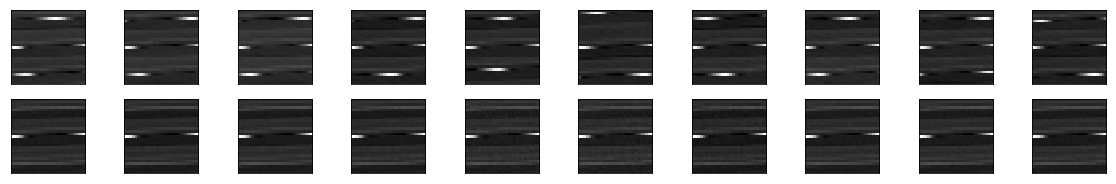

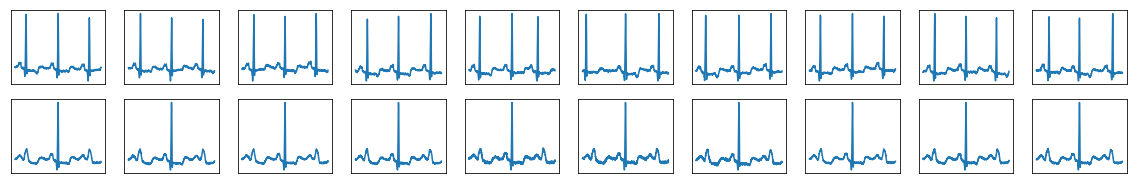

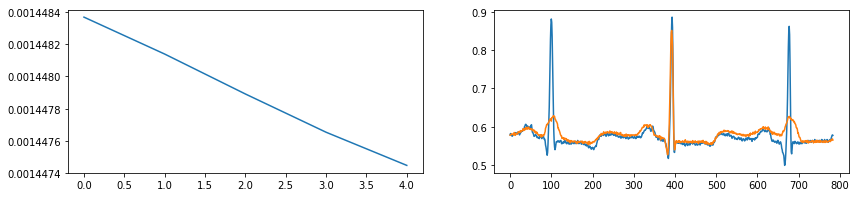

In [38]:
run(create_encoders(784, [], 64), shape=(784,), epochs=5, filename='784_64.h5')

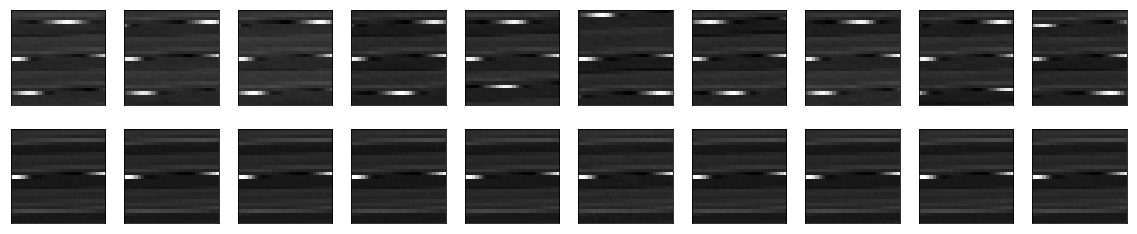

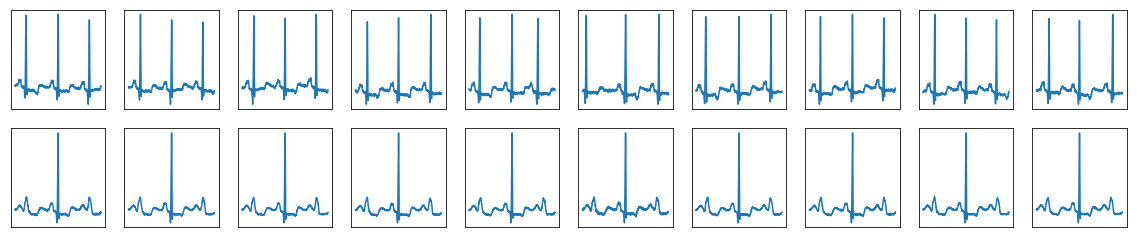

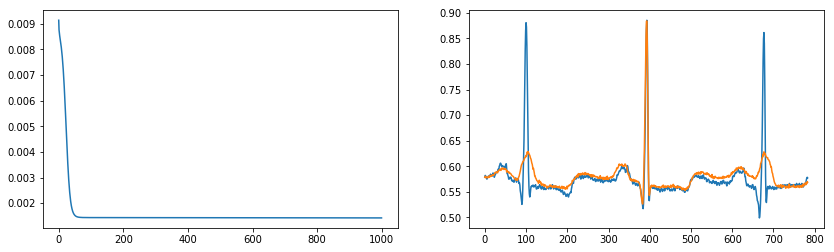

In [53]:
run(*create_encoders(784, [256, 128], 64), epochs=1000)

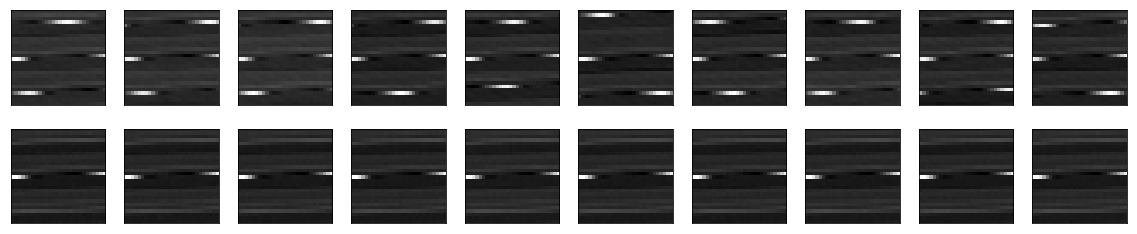

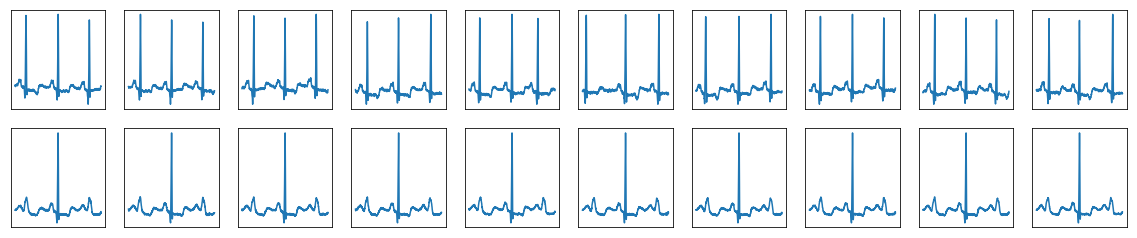

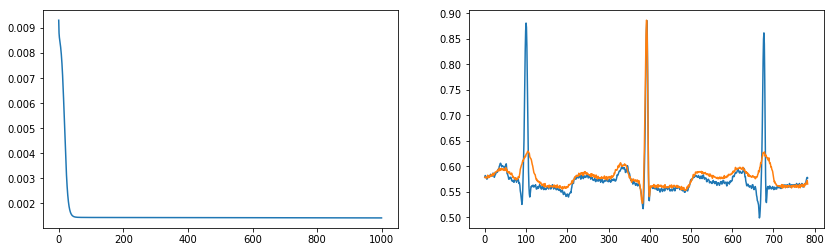

In [54]:
run(*create_encoders(784, [512], 64), epochs=1000)

Train on 2235 samples, validate on 2235 samples
Epoch 1/1000
2235/2235 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0079
Epoch 2/1000
2235/2235 [==============================] - 0s - loss: 0.0076 - val_loss: 0.0070
Epoch 3/1000
2235/2235 [==============================] - 0s - loss: 0.0066 - val_loss: 0.0055
Epoch 4/1000
2235/2235 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0034
Epoch 5/1000
2235/2235 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0029
Epoch 6/1000
2235/2235 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0028
Epoch 7/1000
2235/2235 [==============================] - 0s - loss: 0.0028 - val_loss: 0.0028
Epoch 8/1000
2235/2235 [==============================] - 0s - loss: 0.0028 - val_loss: 0.0028
Epoch 9/1000
2235/2235 [==============================] - 0s - loss: 0.0027 - val_loss: 0.0027
Epoch 10/1000
2235/2235 [==============================] - 0s - loss: 0.0027 - val_loss: 0.0027
E

2235/2235 [==============================] - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 170/1000
2235/2235 [==============================] - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 171/1000
2235/2235 [==============================] - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 172/1000
2235/2235 [==============================] - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 173/1000
2235/2235 [==============================] - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 174/1000
2235/2235 [==============================] - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 175/1000
2235/2235 [==============================] - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 176/1000
2235/2235 [==============================] - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 177/1000
2235/2235 [==============================] - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 178/1000
2235/2235 [==============================] - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 179/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 338/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0020
Epoch 339/1000
2235/2235 [==============================] - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 340/1000
2235/2235 [==============================] - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 341/1000
2235/2235 [==============================] - 0s - loss: 0.0020 - val_loss: 0.0019
Epoch 342/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 343/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 344/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 345/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 346/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 347/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 506/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 507/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 508/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 509/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0018
Epoch 510/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 511/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 512/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 513/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 514/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 515/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 674/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 675/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 676/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 677/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 678/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 679/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 680/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 681/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 682/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 683/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 842/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 843/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 844/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 845/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 846/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0016
Epoch 847/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0016
Epoch 848/1000
2235/2235 [==============================] - 0s - loss: 0.0016 - val_loss: 0.0016
Epoch 849/1000
2235/2235 [==============================] - 0s - loss: 0.0016 - val_loss: 0.0016
Epoch 850/1000
2235/2235 [==============================] - 0s - loss: 0.0016 - val_loss: 0.0016
Epoch 851/1000
2235/2235 [===================

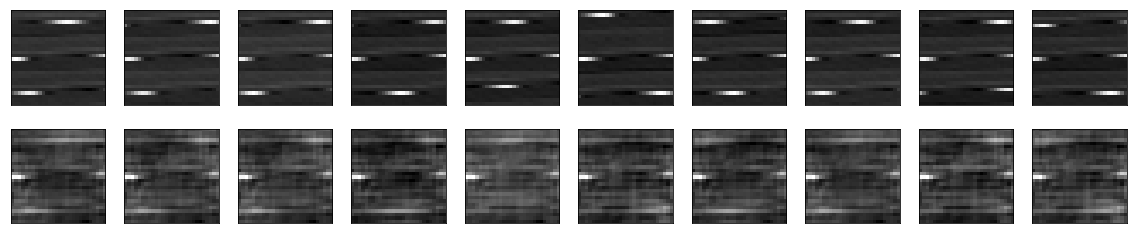

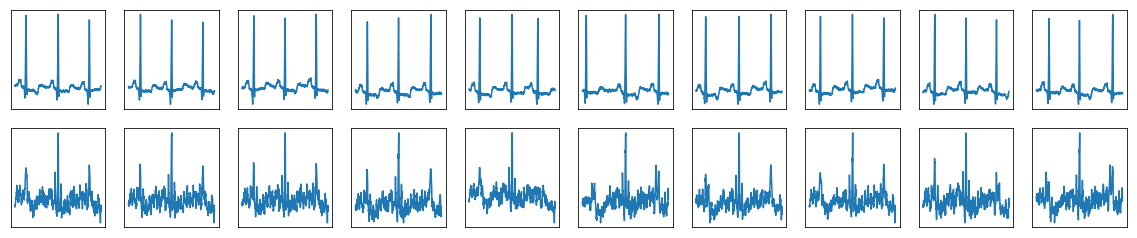

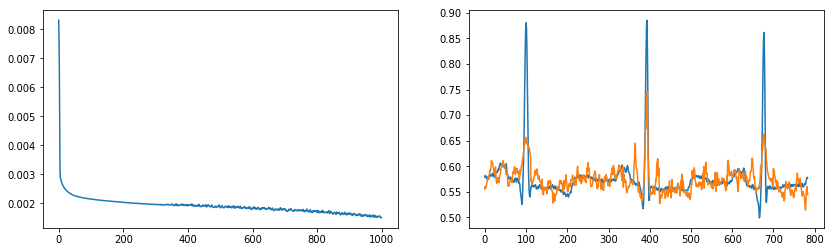

In [19]:
 time% run(*create_conv_encoders(), shape=(28,28,1), epochs=1000)
    

Train on 2235 samples, validate on 2235 samples
Epoch 1/1000
2235/2235 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0079
Epoch 2/1000
2235/2235 [==============================] - 0s - loss: 0.0076 - val_loss: 0.0070
Epoch 3/1000
2235/2235 [==============================] - 0s - loss: 0.0066 - val_loss: 0.0055
Epoch 4/1000
2235/2235 [==============================] - 0s - loss: 0.0047 - val_loss: 0.0034
Epoch 5/1000
2235/2235 [==============================] - 0s - loss: 0.0031 - val_loss: 0.0029
Epoch 6/1000
2235/2235 [==============================] - 0s - loss: 0.0029 - val_loss: 0.0028
Epoch 7/1000
2235/2235 [==============================] - 0s - loss: 0.0028 - val_loss: 0.0028
Epoch 8/1000
2235/2235 [==============================] - 0s - loss: 0.0028 - val_loss: 0.0028
Epoch 9/1000
2235/2235 [==============================] - 0s - loss: 0.0027 - val_loss: 0.0027
Epoch 10/1000
2235/2235 [==============================] - 0s - loss: 0.0027 - val_loss: 0.0027
E

2235/2235 [==============================] - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 170/1000
2235/2235 [==============================] - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 171/1000
2235/2235 [==============================] - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 172/1000
2235/2235 [==============================] - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 173/1000
2235/2235 [==============================] - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 174/1000
2235/2235 [==============================] - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 175/1000
2235/2235 [==============================] - 0s - loss: 0.0021 - val_loss: 0.0021
Epoch 176/1000
2235/2235 [==============================] - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 177/1000
2235/2235 [==============================] - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 178/1000
2235/2235 [==============================] - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 179/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 338/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0020
Epoch 339/1000
2235/2235 [==============================] - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 340/1000
2235/2235 [==============================] - 0s - loss: 0.0020 - val_loss: 0.0020
Epoch 341/1000
2235/2235 [==============================] - 0s - loss: 0.0020 - val_loss: 0.0019
Epoch 342/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 343/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 344/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 345/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 346/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 347/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 506/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 507/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 508/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 509/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0018
Epoch 510/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 511/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 512/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 513/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 514/1000
2235/2235 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0019
Epoch 515/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 674/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 675/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 676/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 677/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 678/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 679/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 680/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 681/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 682/1000
2235/2235 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 683/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 842/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 843/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 844/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 845/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 846/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0016
Epoch 847/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0016
Epoch 848/1000
2235/2235 [==============================] - 0s - loss: 0.0016 - val_loss: 0.0016
Epoch 849/1000
2235/2235 [==============================] - 0s - loss: 0.0016 - val_loss: 0.0016
Epoch 850/1000
2235/2235 [==============================] - 0s - loss: 0.0016 - val_loss: 0.0016
Epoch 851/1000
2235/2235 [===================

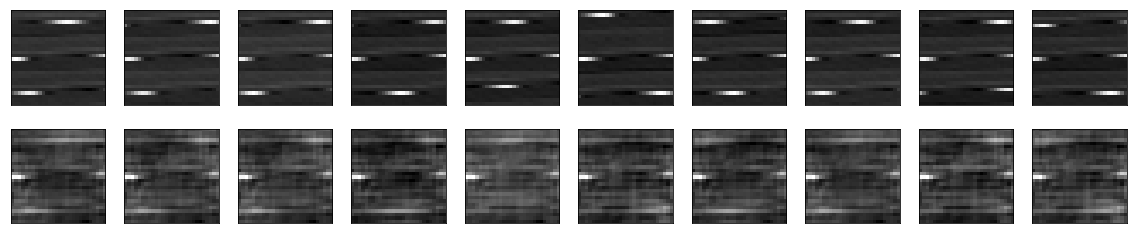

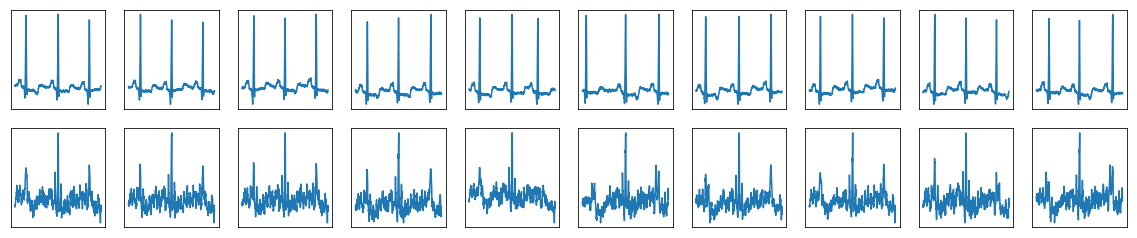

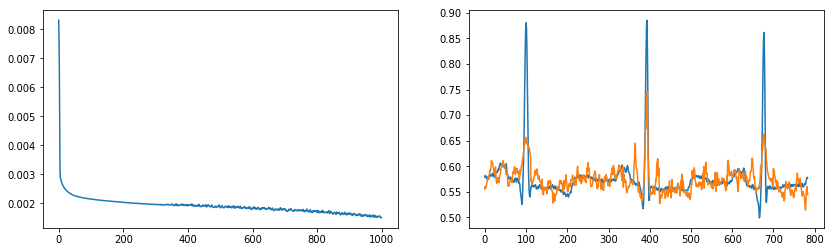

In [19]:
 time% run(*create_conv_encoders(), shape=(28,28,1), epochs=1000)
    

### Batch normalization

Can't load weights to model Dimension 0 in both shapes must be equal, but are 3 and 8 for 'Assign_929' (op: 'Assign') with input shapes: [3,3,1,16], [8,1,3,3].
Train on 2235 samples, validate on 2235 samples
Epoch 1/1000
2235/2235 [==============================] - 1s - loss: 0.0103 - val_loss: 0.0083
Epoch 2/1000
2235/2235 [==============================] - 0s - loss: 0.0066 - val_loss: 0.0079
Epoch 3/1000
2235/2235 [==============================] - 0s - loss: 0.0053 - val_loss: 0.0076
Epoch 4/1000
2235/2235 [==============================] - 1s - loss: 0.0045 - val_loss: 0.0072
Epoch 5/1000
2235/2235 [==============================] - 1s - loss: 0.0039 - val_loss: 0.0069
Epoch 6/1000
2235/2235 [==============================] - 1s - loss: 0.0036 - val_loss: 0.0066
Epoch 7/1000
2235/2235 [==============================] - 0s - loss: 0.0034 - val_loss: 0.0064
Epoch 8/1000
2235/2235 [==============================] - 0s - loss: 0.0032 - val_loss: 0.0061
Epoch 9/1000
2235/2235 [========

2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0018
Epoch 169/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 170/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 171/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 172/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 173/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 174/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 175/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 176/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 177/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0017
Epoch 178/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 337/1000
2235/2235 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 338/1000
2235/2235 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 339/1000
2235/2235 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 340/1000
2235/2235 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 341/1000
2235/2235 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 342/1000
2235/2235 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 343/1000
2235/2235 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 344/1000
2235/2235 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 345/1000
2235/2235 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 346/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0010
Epoch 505/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0010
Epoch 506/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0010
Epoch 507/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0010
Epoch 508/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0010
Epoch 509/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0010
Epoch 510/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0010
Epoch 511/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0010
Epoch 512/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0010
Epoch 513/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0010
Epoch 514/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 8.7928e-04 - val_loss: 8.8273e-04
Epoch 662/1000
2235/2235 [==============================] - 0s - loss: 8.7765e-04 - val_loss: 8.8245e-04
Epoch 663/1000
2235/2235 [==============================] - 0s - loss: 8.7691e-04 - val_loss: 8.8094e-04
Epoch 664/1000
2235/2235 [==============================] - 0s - loss: 8.7620e-04 - val_loss: 8.8529e-04
Epoch 665/1000
2235/2235 [==============================] - 0s - loss: 8.7640e-04 - val_loss: 8.8783e-04
Epoch 666/1000
2235/2235 [==============================] - 0s - loss: 8.7500e-04 - val_loss: 8.8041e-04
Epoch 667/1000
2235/2235 [==============================] - 0s - loss: 8.7402e-04 - val_loss: 8.8239e-04
Epoch 668/1000
2235/2235 [==============================] - 0s - loss: 8.7353e-04 - val_loss: 8.8103e-04
Epoch 669/1000
2235/2235 [==============================] - 0s - loss: 8.7290e-04 - val_loss: 8.7833e-04
Epoch 670/1000
2235/2235 [==============================] - 0s - loss:

2235/2235 [==============================] - 0s - loss: 7.9007e-04 - val_loss: 7.9595e-04
Epoch 818/1000
2235/2235 [==============================] - 0s - loss: 7.8942e-04 - val_loss: 7.9137e-04
Epoch 819/1000
2235/2235 [==============================] - 0s - loss: 7.8855e-04 - val_loss: 7.9003e-04
Epoch 820/1000
2235/2235 [==============================] - 0s - loss: 7.8867e-04 - val_loss: 7.8979e-04
Epoch 821/1000
2235/2235 [==============================] - 0s - loss: 7.8783e-04 - val_loss: 7.9162e-04
Epoch 822/1000
2235/2235 [==============================] - 0s - loss: 7.8744e-04 - val_loss: 7.8963e-04
Epoch 823/1000
2235/2235 [==============================] - 0s - loss: 7.8659e-04 - val_loss: 7.9379e-04
Epoch 824/1000
2235/2235 [==============================] - 0s - loss: 7.8654e-04 - val_loss: 7.9079e-04
Epoch 825/1000
2235/2235 [==============================] - 0s - loss: 7.8574e-04 - val_loss: 7.8823e-04
Epoch 826/1000
2235/2235 [==============================] - 0s - loss:

2235/2235 [==============================] - 0s - loss: 7.2463e-04 - val_loss: 7.2637e-04
Epoch 974/1000
2235/2235 [==============================] - 0s - loss: 7.2358e-04 - val_loss: 7.2480e-04
Epoch 975/1000
2235/2235 [==============================] - 0s - loss: 7.2303e-04 - val_loss: 7.2403e-04
Epoch 976/1000
2235/2235 [==============================] - 0s - loss: 7.2293e-04 - val_loss: 7.2366e-04
Epoch 977/1000
2235/2235 [==============================] - 0s - loss: 7.2252e-04 - val_loss: 7.3114e-04
Epoch 978/1000
2235/2235 [==============================] - 0s - loss: 7.2227e-04 - val_loss: 7.3004e-04
Epoch 979/1000
2235/2235 [==============================] - 0s - loss: 7.2221e-04 - val_loss: 7.2188e-04
Epoch 980/1000
2235/2235 [==============================] - 0s - loss: 7.2182e-04 - val_loss: 7.2332e-04
Epoch 981/1000
2235/2235 [==============================] - 0s - loss: 7.2127e-04 - val_loss: 7.2183e-04
Epoch 982/1000
2235/2235 [==============================] - 0s - loss:

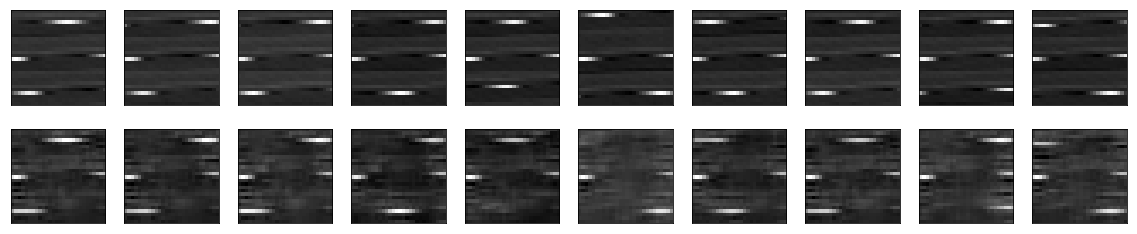

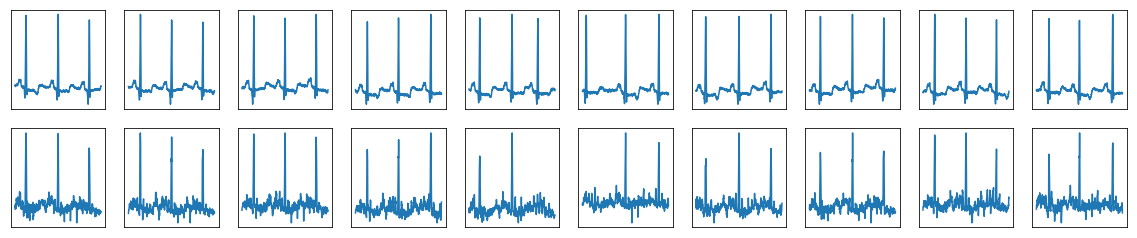

CPU times: user 12min 27s, sys: 1min 58s, total: 14min 26s
Wall time: 15min 55s


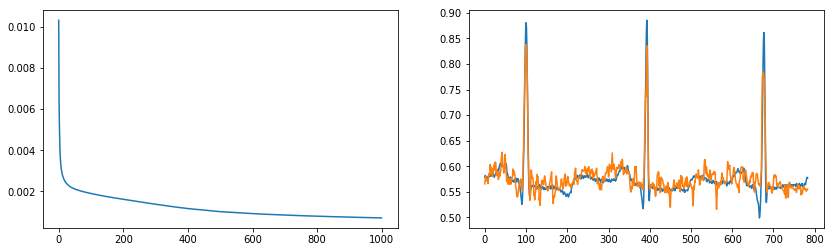

In [58]:
%time run(*create_conv_encoders(), shape=(28,28,1), weights_filename = 'bn.h5', epochs=1000)

### Smooth data and bn

Can't load weights to model Unable to open file (Unable to open file: name = 'bn_smooth_data.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)
Train on 2235 samples, validate on 2235 samples
Epoch 1/1000
2235/2235 [==============================] - 1s - loss: 0.0167 - val_loss: 0.0084
Epoch 2/1000
2235/2235 [==============================] - 0s - loss: 0.0083 - val_loss: 0.0082
Epoch 3/1000
2235/2235 [==============================] - 0s - loss: 0.0054 - val_loss: 0.0080
Epoch 4/1000
2235/2235 [==============================] - 0s - loss: 0.0044 - val_loss: 0.0080
Epoch 5/1000
2235/2235 [==============================] - 0s - loss: 0.0040 - val_loss: 0.0079
Epoch 6/1000
2235/2235 [==============================] - 0s - loss: 0.0037 - val_loss: 0.0079
Epoch 7/1000
2235/2235 [==============================] - 0s - loss: 0.0035 - val_loss: 0.0078
Epoch 8/1000
2235/2235 [==============================] - 0s - loss: 0.0033 - val_loss: 0.0078
Epoch 9/1000
2

2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0037
Epoch 85/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0036
Epoch 86/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0036
Epoch 87/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0036
Epoch 88/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0035
Epoch 89/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0034
Epoch 90/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0034
Epoch 91/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0034
Epoch 92/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0032
Epoch 93/1000
2235/2235 [==============================] - 0s - loss: 0.0017 - val_loss: 0.0032
Epoch 94/1000
2235/2235 [=============================

2235/2235 [==============================] - 0s - loss: 0.0013 - val_loss: 0.0013
Epoch 253/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 254/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 255/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 256/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 257/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 258/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 259/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 260/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0013
Epoch 261/1000
2235/2235 [==============================] - 0s - loss: 0.0012 - val_loss: 0.0012
Epoch 262/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 421/1000
2235/2235 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 422/1000
2235/2235 [==============================] - 0s - loss: 0.0011 - val_loss: 0.0011
Epoch 423/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 424/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 425/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 426/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 427/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 428/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0011
Epoch 429/1000
2235/2235 [==============================] - 0s - loss: 0.0010 - val_loss: 0.0010
Epoch 430/1000
2235/2235 [===================

2235/2235 [==============================] - 0s - loss: 9.1158e-04 - val_loss: 9.1698e-04
Epoch 581/1000
2235/2235 [==============================] - 0s - loss: 9.1125e-04 - val_loss: 9.1629e-04
Epoch 582/1000
2235/2235 [==============================] - 0s - loss: 9.1033e-04 - val_loss: 9.1134e-04
Epoch 583/1000
2235/2235 [==============================] - 0s - loss: 9.0921e-04 - val_loss: 9.1801e-04
Epoch 584/1000
2235/2235 [==============================] - 0s - loss: 9.0861e-04 - val_loss: 9.1092e-04
Epoch 585/1000
2235/2235 [==============================] - 0s - loss: 9.0807e-04 - val_loss: 9.1028e-04
Epoch 586/1000
2235/2235 [==============================] - 0s - loss: 9.0717e-04 - val_loss: 9.1201e-04
Epoch 587/1000
2235/2235 [==============================] - 0s - loss: 9.0602e-04 - val_loss: 9.1479e-04
Epoch 588/1000
2235/2235 [==============================] - 0s - loss: 9.0521e-04 - val_loss: 9.1107e-04
Epoch 589/1000
2235/2235 [==============================] - 0s - loss:

2235/2235 [==============================] - 0s - loss: 8.0933e-04 - val_loss: 8.1062e-04
Epoch 737/1000
2235/2235 [==============================] - 0s - loss: 8.0885e-04 - val_loss: 8.1080e-04
Epoch 738/1000
2235/2235 [==============================] - 0s - loss: 8.0818e-04 - val_loss: 8.1295e-04
Epoch 739/1000
2235/2235 [==============================] - 0s - loss: 8.0765e-04 - val_loss: 8.0920e-04
Epoch 740/1000
2235/2235 [==============================] - 0s - loss: 8.0735e-04 - val_loss: 8.0786e-04
Epoch 741/1000
2235/2235 [==============================] - 0s - loss: 8.0657e-04 - val_loss: 8.0956e-04
Epoch 742/1000
2235/2235 [==============================] - 0s - loss: 8.0615e-04 - val_loss: 8.0733e-04
Epoch 743/1000
2235/2235 [==============================] - 0s - loss: 8.0540e-04 - val_loss: 8.1024e-04
Epoch 744/1000
2235/2235 [==============================] - 0s - loss: 8.0509e-04 - val_loss: 8.0603e-04
Epoch 745/1000
2235/2235 [==============================] - 0s - loss:

2235/2235 [==============================] - 0s - loss: 7.3131e-04 - val_loss: 7.3064e-04
Epoch 893/1000
2235/2235 [==============================] - 0s - loss: 7.3046e-04 - val_loss: 7.3061e-04
Epoch 894/1000
2235/2235 [==============================] - 0s - loss: 7.2993e-04 - val_loss: 7.2975e-04
Epoch 895/1000
2235/2235 [==============================] - 0s - loss: 7.2927e-04 - val_loss: 7.3114e-04
Epoch 896/1000
2235/2235 [==============================] - 0s - loss: 7.2912e-04 - val_loss: 7.3010e-04
Epoch 897/1000
2235/2235 [==============================] - 0s - loss: 7.2835e-04 - val_loss: 7.2863e-04
Epoch 898/1000
2235/2235 [==============================] - 0s - loss: 7.2820e-04 - val_loss: 7.2792e-04
Epoch 899/1000
2235/2235 [==============================] - 0s - loss: 7.2780e-04 - val_loss: 7.2789e-04
Epoch 900/1000
2235/2235 [==============================] - 0s - loss: 7.2720e-04 - val_loss: 7.2774e-04
Epoch 901/1000
2235/2235 [==============================] - 0s - loss:

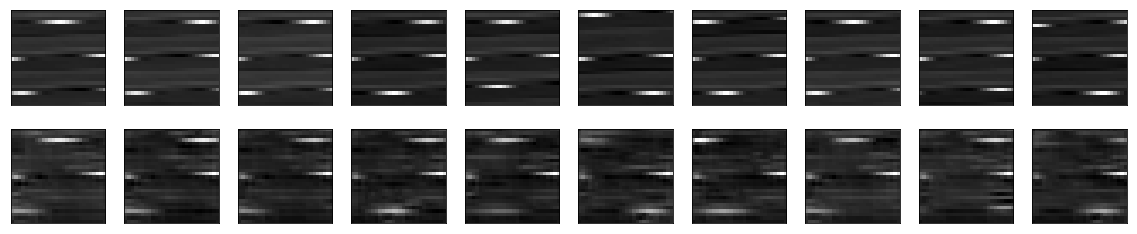

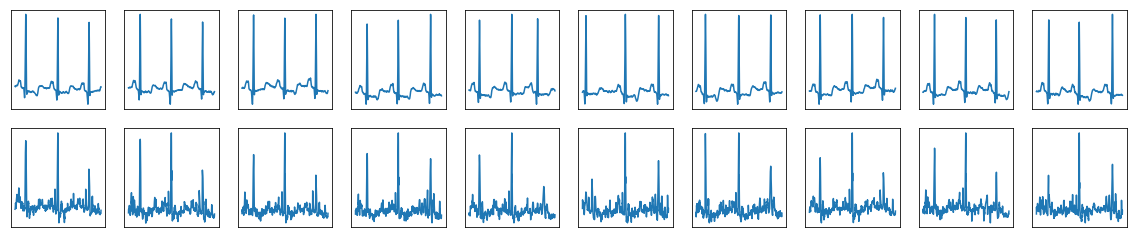

CPU times: user 10min 59s, sys: 1min 43s, total: 12min 43s
Wall time: 13min 32s


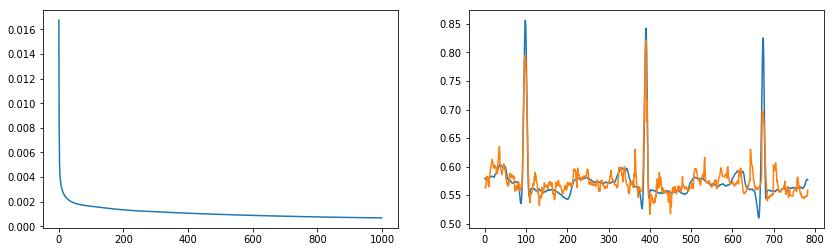

In [64]:
%time run(*create_conv_encoders(), shape=(28,28,1), weights_filename = 'bn_smooth_data.h5', epochs=1000)